## Import Statements

In [10]:
import numpy as np
import pypico
import time as t
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import LambdaCDM
import emcee
import corner
import os
import imageio

## Load data (WMAP, PICO, SNe Ia)

In [11]:
#Load the wmap satellite data
wmap = np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
multipole = wmap[:,0] 
power = wmap[:,1] 
errPower = wmap[:,2]

#Load the pico training data
pico = pypico.load_pico("jcset_py3.dat")

#Load the SNe Ia data
sn_z,sn_dm,sn_dm_err = np.loadtxt("SCPUnion2.1_mu_vs_z.txt",delimiter="\t",skiprows=5, usecols = (1,2,3),unpack=True)

## Posterior Probability Function for WMAP

In [12]:
def get_PICO_spectrum(pars):
    """
    Function to evaluate the CAMB model emulator for a given set of parameters. 
    Much faster than the full CAMB model
    """
    
    H0, ombh2, omch2, omk, tau, As, ns, alpha = pars #Unpack model parameters
    
    input_dict = {"As": As,"ns": ns,"tau": tau,"ombh2":ombh2,"omch2":omch2,"H0":H0,"omk":omk}
    #force=True will make pico evaluate the emulator even if we are outside the training data domain
    #Alternatively could catch the CantUsePICO error and evaluate CAMB, but force should work fine
    output_dict = pico.get(**input_dict, force=True)
    tt = output_dict['dl_TT']
    
    return tt

In [13]:
def get_cov_model(err, alpha):
    """
    Evaluate the covariance matrix using a model where adjacent points have a correlation 
    scaled by the parameter alpha
    
    0.16 seconds with vectorization, 0.36 seconds with for loops
    """
    N = len(err)
    C = np.zeros([N,N])
    #Compute each element in the covariance matrix
    err_shift_1 = np.roll(err,-1) #Get the error shifted by one, to compute k=1 correlation terms
    #Compute the diagonal and k=1 terms
    diag_terms = err**2
    diag_k1_terms = alpha*np.abs(err[0:-1]*err_shift_1[0:-1]) #Should I take the absolute value?
    #Cast the terms into matrix form and combine to get the final covariance matrix
    C_diag = np.diag(np.array(diag_terms))
    C_diag_k1 = np.diag(np.array(diag_k1_terms), k=1)
    C_diag_km1 = np.diag(np.array(diag_k1_terms), k=-1)
    C = C_diag + C_diag_k1 + C_diag_km1
    
    return C

def log_likelihood_WMAP(theta, multipole, p_data, err, covariance_model):
    """
    Evaluate the chi-sq metric of a PICO fit with a neighbour-correlation model or
    an uncorrelated error model, given a set of model parameters stored in the array theta
    
    Return the log likelihood probability, which is equal to -chi_sq
    """
    
    #Get p_model using get_PICO_spectrum(theta)
    pico_tt = get_PICO_spectrum(theta) #Note that the last element of theta isn't used, but it shouldnt cause a problem because I read the theta values out properly in get_PICO_spectrum
    p_model = pico_tt[2:len(multipole)+2]
    
    if covariance_model == 'correlated':
        alpha = theta[7] #Get the covariance scaling parameter

        At = np.array([p_data - p_model])
        A = np.transpose(At)
        C_inv = np.linalg.inv(get_cov_model(err, alpha))

        chi_sq = np.dot(At, np.dot(C_inv,A))[0,0] #Evaluate the matrix multiplication of chi-squared terms

    elif covariance_model == 'uncorrelated':
        x = np.asarray(p_data)
        y = np.asarray(p_model)
        error = np.asarray(err)
        
        chi_sq = sum((x-y)**2/error**2)

    return -chi_sq

def log_prior_WMAP(theta):
    """
    Evaluate the log prior probability function given model parameters
    
    Return 0.0 if the parameters fall within our constraints, else return -np.inf
    """
    H0, ombh2, omch2, omk, tau, As, ns, alpha = theta #Unpack model parameters
    
    #Convert units of Omega params
    h = H0/100
    Omb = ombh2/(h**2)
    Omde = omch2/(h**2)
    
    #Check that the params are allowed by our physical constraints
    if 0. <= Omb <= 1. and 0. < Omde < 1. and -1.<=alpha<=1.:
        return 0.0 # the constant doesn't matter since MCMCs only care about *ratios* of probabilities
    return -np.inf # log(0) = -inf

def log_post_WMAP(theta, multipole, p_data, err, covariance_model):
    """
    Evaluate the log posterior probability function given WMAP data and model parameters
    """
    lp = log_prior_WMAP(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_WMAP(theta, multipole, p_data, err, covariance_model)

In [14]:
#Test the log_post_WMAP function using a dummy set of parameter values
pars_initialGuess=np.asarray([70,0.02,0.1,0.0,0.05,2e-9,0.97,0.07])
covariance_model = 'correlated'

t1 = t.time()
p_log_post = log_post_WMAP(pars_initialGuess, multipole, power, errPower, covariance_model)
t2 = t.time()
print(t2-t1,'seconds per log_post_WMAP call')
print('Log Posterior value for the given params:',p_log_post)

0.38057589530944824 seconds per log_post_WMAP call
Log Posterior value for the given params: -1412.6132674433113


## MCMC Helper Functions

MCMC Animation

In [15]:
def plot_SNe_sample(x_data, flat_samples, ind):
    #Get the parameters, create the corresponding cosmo model, and evaluate mu
    sample = flat_samples[ind]
    H0, Om0, Ode0 = sample
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0) 
    y_model = mu_func(x_data, cosmo)
    #Plot the fit for these parameters
    plt.plot(x_data, y_model, alpha=0.01, color='red',zorder=2)
    #Save the figure to add to the animation
    fig_name = 'frame'+str(ind)+'.png'
    plt.savefig(fig_name)
    
    return fig_name

def plot_WMAP_sample(x_data, flat_samples, ind):
    #Get the parameters and evaluate the corresponding PICO model
    sample = flat_samples[ind]
    y_model = get_PICO_spectrum(sample)
    y_model = y_model[2:len(x_data)+2]
    #Plot the fit for these parameters
    plt.plot(x_data, y_model, alpha=0.01, color='red',zorder=2)
    #Save the figure to add to the animation
    fig_name = 'frame'+str(ind)+'.png'
    plt.savefig(fig_name)
    
    return fig_name
    
def write_animation(fig_name_list, filename):
    """
    Take a series of .png frames and animate them into a .gif
    """
    # build gif from the frames in the directory
    with imageio.get_writer(filename, mode='I') as writer:
        for fig_name in fig_name_list:
            image = imageio.imread(fig_name)
            writer.append_data(image)

    # Clear the files from the directory files
    for fig_name in set(fig_name_list):
        os.remove(fig_name)
        
    print('Animation saved as ', filename)

def MCMC_animation(sampler, x_data, y_data, y_err, dataset, filename, N_samples):
    """
    Create an animation of the first N_samples of the MCMC fit
    """
    
    #Plot the original data
    plt.figure(figsize=(7,7))
    if dataset == 'SNe':
        plt.plot(x_data, y_data,'.k')
        #plt.errorbar(x_data, y_data, yerr=y_err, linestyle = 'None', fmt='.k',mec='black',mfc='black',ecolor='grey',zorder=1)
        plt.xlabel(r'$z$')
        plt.ylabel(r'$m-M (Mag)$')
        plt.xscale('log')
        plt.title('SCP Union 2.1 SNe Ia Data')
    if dataset =='WMAP':
        plt.plot(multipole,power)
        #plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
        plt.xlabel('Multipole Moment')
        plt.ylabel('Power Spectrum')
        plt.title('WMAP Satellite 9-year CMB Data')
        plt.legend()
    
    #Get the samples to plot
    flat_samples = sampler.get_chain(flat=True)[:N_samples]
    
    #Plot each sample and save the plot frame as a .png
    fig_name_list = []
    for ind in range(N_samples):
        if dataset == 'SNe':
            fig_name = plot_SNe_sample(x_data, flat_samples, ind)
        if dataset == 'WMAP':
            fig_name = plot_WMAP_sample(x_data, flat_samples, ind)
        #Store the frame filename
        fig_name_list.append(fig_name)
        
    #Collect the .png frames and save them as a .gif animation
    write_animation(fig_name_list, filename)

## WMAP MCMC Fitting

WMAP MCMC Animation

In [67]:
#Check tau_f to tune MCMC, show corner plots of results
#Plot the posterior fit with the data
#Convert omega*h^2 values to omega

def run_mcmc(log_posterior, args, ndim, nwalkers, initial_pos, backend_filename, do_burn_in, plot_convergence=True, num_iter=1000, burn_in=0,thin=0):
    """
    Function which will either run MCMC with unknown burn-in time just until convergence (do_burn_in=True) 
    OR with known burn-in, thinning, and number of iterations. 
    
    """
    # Set up the backend JUST IN CASE
    backend = emcee.backends.HDFBackend(backend_filename)
    backend.reset(nwalkers, ndim) #reset if it's already been created

    # Initialize the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=args)
    
    if(do_burn_in):
        #run until converged , with the option of plotting convergence
        autocorr, tau = mcmc_burn_in(sampler,plot_convergence)
    
        burn_in = int(2 * np.max(tau))
        thin = int(0.5 * np.min(tau))
        
        print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(tau)))
        print("burn-in: {0}".format(burn_in))
        print("thin: {0}".format(thin))
    else:
        #run with number of iterations and default 
        flat_samples = sampler.run_mcmc(initial_pos, num_iter, progress=True)
        
    flat_samples = sampler.get_chain(discard=burn_in, flat=True, thin=thin)
    return sampler, flat_samples , burn_in , thin

def plot_convergence(autocorr,index):
    n = 100 * np.arange(1, index + 1)
    y = autocorr[:index]
    plt.plot(n, n / 100.0, "--k")
    plt.plot(n, y)
    plt.xlim(0, n.max())
    plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
    plt.xlabel("number of steps")
    plt.ylabel(r"mean $\hat{\tau}$")
    plt.show()
    
def mcmc_burn_in(sampler,plot,max_n=100000):
    #(the following code is adapted from an emcee tutorial)
    #run mcmc for maximum 100,000 steps, or until converged

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(initial_pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau
    
    tau = sampler.get_autocorr_time()
    
    if(plot):
        plot_convergence(autocorr,index)
    
    return autocorr, tau


In [37]:
import h5py

In [75]:
ndim = 8 # number of parameters
nwalkers = 20 #number of walkers

#set up initial guesses
H0_initial = 70
ombh2_initial =0.02
omch2_initial = 0.1
omk_initial = 0
tau_initial = 0.05
As_initial = 2e-9
ns_initial = 0.97
alpha_initial = 0.07
pars_initialGuess=np.asarray([H0_initial, ombh2_initial, omch2_initial, omk_initial, tau_initial, As_initial, ns_initial, alpha_initial])

initial_pos = pars_initialGuess + 0.01 * np.random.randn(nwalkers, ndim) #gaussian ball of walkers

args = (multipole, power, errPower, covariance_model)

backend_filename = "wmap_chain.h5"

sampler_WMAP, flat_samples_WMAP, burn_in_WMAP, thin_WMAP = run_mcmc(log_post_WMAP, args, ndim, nwalkers, initial_pos, backend_filename, True)

#Corner plot
labels = ["H0", "Om0", "Ode0"]
fig = corner.corner(flat_samples_WMAP, bins = 50, labels=labels, show_titles=True, quantiles=[0.16, 0.5, 0.84]);

  0%|          | 165/100000 [14:43<131:09:07,  4.73s/it]

emcee: Exception while calling your likelihood function:
  params: [ 6.99998172e+01  2.17220751e-02  1.00140912e-01 -3.89250042e-03
  4.99543487e-02  1.92883863e-09  9.61099614e-01  8.04651976e-02]
  args: (array([   2.,    3.,    4., ..., 1198., 1199., 1200.]), array([  150.6398,   902.1805,   730.3626, ...,  2322.1509, -4873.3315,
        7194.978 ]), array([ 708.3154,  565.3141,  471.9324, ..., 5726.6724, 5775.1737,
       5811.3539]), 'correlated')
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/katiesavard/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-13-002185a00e0d>", line 78, in log_post_WMAP
    return lp + log_likelihood_WMAP(theta, multipole, p_data, err, covariance_model)
  File "<ipython-input-13-002185a00e0d>", line 40, in log_likelihood_WMAP
    C_inv = np.linalg.inv(get_cov_model(err, alpha))
  File "/Users/katiesavard/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
KeyboardInterrupt



KeyboardInterrupt: 

In [ ]:
filename = 'WMAP_MCMC_animation.gif'
dataset = 'WMAP'
N_samples = 100
#Create animation of MCMC fitting
MCMC_animation(sampler_WMAP, multipole, power, errPower, dataset, filename, N_samples)

## Posterior Probability Function for SNe Ia

In [39]:
def mu_func(z, cosmo):
    """
    Given a redshift value z and universe model cosmo, convert to luminosity distance and calculate 
    the distance modulus mu (aka m-M)
    
    Return mu
    """
    D_L = cosmo.luminosity_distance(z).value
    mu = 5*np.log10(D_L)+25
    return mu

def log_likelihood_sn(theta, z, mu_data, mu_err):
    #Get the parameters and create the corresponding cosmo model
    H0, Om0, Ode0 = theta
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    #Evaluate the model at the data point z values
    mu_model = mu_func(z, cosmo)
    
    sigma2 = mu_err ** 2
    return -0.5 * np.sum((mu_data - mu_model) ** 2 / sigma2 + np.log(2*np.pi*sigma2)) # the 2pi factor doesn't affect the shape

def log_prior_sn(theta):
    H0, Om0, Ode0 = theta
    #Check that the params are allowed by our physical constraints
    if 0. <= Om0 <= 1. and 0. < Ode0 < 1.:
        return 0.0 # the constant doesn't matter since MCMCs only care about *ratios* of probabilities
    return -np.inf # log(0) = -inf

def log_post_sn(theta, z, mu_data, mu_err):
    lp = log_prior_sn(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_sn(theta, z, mu_data, mu_err)

## SNe Ia MCMC Fitting

  5%|▌         | 5200/100000 [02:00<36:42, 43.05it/s]  


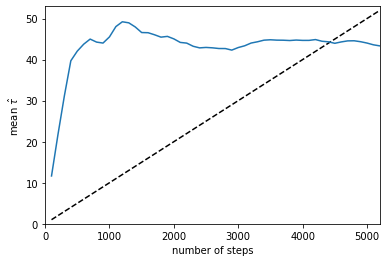

Mean autocorrelation time: 43.336 steps
burn-in: 96
thin: 17


In [61]:
#Check tau_f to tune MCMC, show corner plots of results
#Plot the posterior fit with the data

sn_z,sn_dm,sn_dm_err = np.loadtxt("SCPUnion2.1_mu_vs_z.txt",delimiter="\t",skiprows=5, usecols = (1,2,3),unpack=True)


ndim = 3 # number of parameters
nwalkers = 16

#set up initial guesses
H0_initial = 70
Omc_initial =0.7
Omm_initial = 0.3
pars_initialGuess = np.asarray([H0_initial, ombh2_initial, omch2_initial])

initial_pos = pars_initialGuess + 0.01 * np.random.randn(nwalkers, ndim) #gaussian ball of walkers

args = (sn_z,sn_dm,sn_dm_err)

backend_filename = "SNe_chain.h5"


sampler_SNe, flat_samples_SNe, burn_in_SNe, thin_SNe = run_mcmc(log_post_sn, args, ndim, nwalkers, initial_pos, backend_filename, True)



#Calculate posterior for omega_k = 1 - omega_m - omega_de

In [72]:
sampler_SNe, flat_samples_SNe, burn_in_SNe, thin_SNe = run_mcmc(log_post_sn, args, ndim, nwalkers, initial_pos, backend_filename, do_burn_in=False, num_iter=50000, burn_in=burn_in_SNe,thin=thin_SNe)


100%|██████████| 50000/50000 [22:34<00:00, 43.72it/s]  


In [ ]:
#raw data plot
f, ax = plt.subplots(figsize=(6,4))
ax.errorbar()
ax.errorbar(sn_z, sn_dm, yerr=sn_dm_err, fmt='.k', ecolor='gray')
ax.set_xscale('log')
ax.set_ylabel(r'$m-M$ (mag)')
ax.set_xlabel(r'$z$');

SNe MCMC Animation

Animation saved as  SNe_MCMC_animation.gif


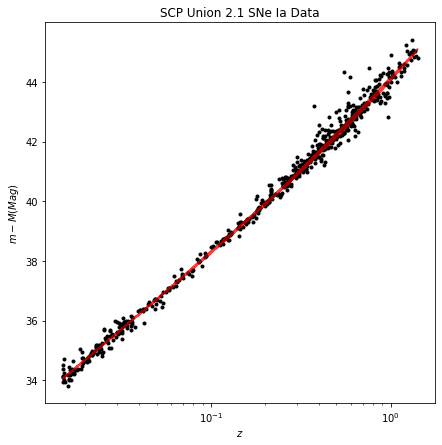

In [55]:
filename = 'SNe_MCMC_animation.gif'
dataset = 'SNe'
N_samples = 100
#Create animation of MCMC fitting
MCMC_animation(sampler_SNe, sn_z, sn_dm, sn_dm_err, dataset, filename, N_samples)

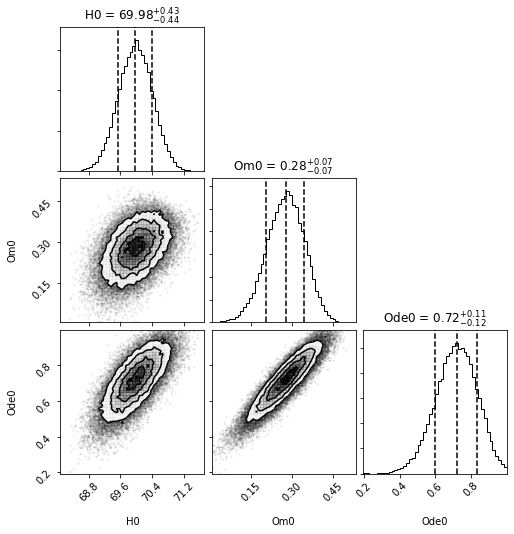

In [73]:
#Corner plot
labels = ["H0", "Om0", "Ode0"]
fig = corner.corner(flat_samples_SNe, bins = 50, labels=labels, show_titles=True, quantiles=[0.16, 0.5, 0.84]);

## Overlay comparison of WMAP and SNe Ia Posterior distributions

In [12]:
#Overlay the posteriors for the omegas to compare between the two measurements
#Maybe include best fit values from Planck?